<a href="https://colab.research.google.com/github/ctorney/learning-to-simulate-tf2/blob/main/test-files/ZonalModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "graph_nets>=1.1" "dm-sonnet>=2.0.0b0" "tensorflow_probability"

In [2]:
#@title ### Imports

import numpy as np
from math import *
import sys
import random
import time

from tqdm import tqdm
import tensorflow as tf
import os

import functools

from sklearn import neighbors

from typing import Callable

import graph_nets as gn
import sonnet as snt
import collections

from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
from matplotlib import animation, rc

# Generate Data

In [75]:
#@title ### Zonal Model

def get_record(group_id,pos,vel):
    feature = { 'group_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[group_id])),
                'pos': tf.train.Feature(bytes_list=tf.train.BytesList(value=[pos.numpy()])),
                'vel': tf.train.Feature(bytes_list=tf.train.BytesList(value=[vel.numpy()]))
                }
    return tf.train.Example(features=tf.train.Features(feature=feature))


class zonal_model:
    def __init__(self, N, timesteps, discard, repeat, L, dt, save_interval,train_directory='train_datasets', valid_directory='valid_datasets', disable_progress=False):
        self.N = N
        self.timesteps = timesteps
        self.discard = discard
        self.B = repeat  # repeat for B batches
        self.L = L
        self.dt = dt
        self.save_interval = save_interval
        
        self.micro_state = np.zeros((self.B, (self.timesteps - self.discard)//self.save_interval, N, 4),dtype=np.float32)

        self.sim_counter=0

        if not os.path.exists(train_directory):
            os.makedirs(train_directory)

        if not os.path.exists(valid_directory):
            os.makedirs(valid_directory)

        self.train_directory = train_directory
        self.valid_directory = valid_directory

        # turn progress bar on or off
        self.disable_progress = disable_progress

        self.valid_fraction = 0.1
        
    def initialise_state(self):

        self.positions = tf.random.uniform((self.B,self.N,2),0.5*self.L, 0.5*self.L+20) #0,self.L)
        #self.positions = tf.random.uniform((self.B,self.N,2),0, self.L) 
        self.angles = tf.random.uniform((self.B,self.N,1), 0, 2*pi) #
        


    def run_sim(self, *params):

        eta, Ra, Ro, Rr, vs, va, sigma = params
        
        record_file = self.train_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.writer = tf.io.TFRecordWriter(record_file) 
        
        valid_file = self.valid_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.validwriter = tf.io.TFRecordWriter(valid_file) 
        
        # tensorflow function to run an update step
        @tf.function
        def update_tf(X, A):
            cos_A = tf.math.cos(A)
            sin_A = tf.math.sin(A)


            Xx = tf.expand_dims(X[...,0],-1)
            dx = -Xx + tf.linalg.matrix_transpose(Xx)
            dx = tf.where(dx>0.5*self.L, dx-self.L, dx)
            dx = tf.where(dx<-0.5*self.L, dx+self.L, dx)

            Xy = tf.expand_dims(X[...,1],-1)
            dy = -Xy + tf.linalg.matrix_transpose(Xy)
            dy = tf.where(dy>0.5*self.L, dy-self.L, dy)
            dy = tf.where(dy<-0.5*self.L, dy+self.L, dy)


            angle_to_neigh = tf.math.atan2(dy, dx)
            cos_N = tf.math.cos(angle_to_neigh)
            sin_N = tf.math.sin(angle_to_neigh)
            rel_angle_to_neigh = angle_to_neigh - A
            rel_angle_to_neigh = tf.math.atan2(tf.math.sin(rel_angle_to_neigh), tf.math.cos(rel_angle_to_neigh))
            
            dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))
    
            # repulsion 
            rep_x = tf.where(dist<=Rr, -dx, tf.zeros_like(dx))
            rep_x = tf.where(rel_angle_to_neigh<0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.where(rel_angle_to_neigh>-0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.math.divide_no_nan(rep_x,tf.math.square(dist))
            rep_x = tf.reduce_sum(rep_x,axis=2)

            rep_y = tf.where(dist<=Rr, -dy, tf.zeros_like(dy))
            rep_y = tf.where(rel_angle_to_neigh<0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.where(rel_angle_to_neigh>-0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.math.divide_no_nan(rep_y,tf.math.square(dist))
            rep_y = tf.reduce_sum(rep_y,axis=2)

            # alignment 
            align_x = tf.where(dist<=Ro, cos_A, tf.zeros_like(cos_A))
            align_x = tf.where(rel_angle_to_neigh<0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.where(rel_angle_to_neigh>-0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.reduce_sum(align_x,axis=1)
            
            align_y = tf.where(dist<=Ro, sin_A, tf.zeros_like(sin_A))
            align_y = tf.where(rel_angle_to_neigh<0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.where(rel_angle_to_neigh>-0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.reduce_sum(align_y,axis=1)

            al_norm = tf.math.sqrt(align_x**2+align_y**2)
            align_x = tf.math.divide_no_nan(align_x,al_norm)
            align_y = tf.math.divide_no_nan(align_y,al_norm)

            # attractive interactions
            attr_x = tf.where(dist<=Ra, dx, tf.zeros_like(dx))
            attr_x = tf.where(rel_angle_to_neigh<0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.where(rel_angle_to_neigh>-0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.reduce_sum(attr_x,axis=2)

            attr_y = tf.where(dist<=Ra, dy, tf.zeros_like(dy))
            attr_y = tf.where(rel_angle_to_neigh<0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.where(rel_angle_to_neigh>-0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.reduce_sum(attr_y,axis=2)

            at_norm = tf.math.sqrt(attr_x**2+attr_y**2)
            attr_x = tf.math.divide_no_nan(attr_x,at_norm)
            attr_y = tf.math.divide_no_nan(attr_y,at_norm)

            # combine angles and convert to desired angle change
            social_x = rep_x + align_x + attr_x
            social_y = rep_y + align_y + attr_y

            d_angle = tf.math.atan2(social_y,social_x)
            d_angle = tf.expand_dims(d_angle,-1)

            
            d_angle = tf.math.atan2((1-eta)*tf.math.sin(d_angle) + eta*sin_A, (1-eta)*tf.math.cos(d_angle) + eta*cos_A)

            d_angle = d_angle - A
            d_angle = tf.where(d_angle>pi, d_angle-2*pi, d_angle)
            d_angle = tf.where(d_angle<-pi, d_angle+2*pi, d_angle)


            # add perception noise
            noise = tf.random.normal(shape=(self.B,self.N,1),mean=0,stddev=sigma*(self.dt**0.5))
            d_angle = d_angle + noise
            
            # restrict to maximum turning angle
            #d_angle = tf.where(tf.math.abs(d_angle)>eta*self.dt, tf.math.sign(d_angle)*eta*self.dt, d_angle)
            
            # rotate headings
            A = A + d_angle
            
            # update positions
            velocity = self.dt*vs*tf.concat([tf.cos(A),tf.sin(A)],axis=-1)
            X += velocity

            # add periodic boundary conditions
            A = tf.where(A<-pi,  A+2*pi, A)
            A = tf.where(A>pi, A-2*pi, A)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            return X, A
            
        self.initialise_state()

        counter=0
        for i in tqdm(range(self.timesteps),disable=self.disable_progress):
            self.positions, self.angles = update_tf(self.positions,  self.angles)
            if i>=self.discard:
                if i%self.save_interval==0:
                    # store in an array in case we want to visualise
                    self.micro_state[:,counter,:,0:2] = self.positions.numpy()
                    self.micro_state[:,counter,:,2:3] = np.cos(self.angles.numpy())
                    self.micro_state[:,counter,:,3:4] = np.sin(self.angles.numpy())
                        
                    

                    counter = counter + 1

        for b in range(self.B):
            self.save_tf_record(b)

        self.writer.close()
        self.validwriter.close()
        self.sim_counter+=1
        return 

    def save_tf_record(self, b):
        pos =  tf.io.serialize_tensor(self.micro_state[b,:,:,0:2])
        vel =  tf.io.serialize_tensor(self.micro_state[b,:,:,2:4])

        tf_record = get_record(b,pos,vel)
        if b> self.B*self.valid_fraction:
            self.writer.write(tf_record.SerializeToString())
        else:
            self.validwriter.write(tf_record.SerializeToString())

        
        return 

In [76]:
#@title ### Params

n_points=50 #10

param_values = np.linspace(0,25,n_points)
L= 200
N= 100 
repeat = 100
discard = 500
timesteps = 500
save_interval=10
dt=0.1


sim = zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval,disable_progress=False)

latt=0  # adapt
lrep= 1 # adapt
lali= 5 # adapt
eta=0.9 # adapt
va=2*pi # adapt
vs=5 # fix 
sigma=0.1 

In [5]:
#@title ### Create Training Data

def evaluate_zonal_model(X):
    sim.run_sim(eta, latt, X, lrep, vs, va, sigma)
    return

evaluate_zonal_model(0)

"""
for i in tqdm(range(param_values.shape[0])):
    evaluate_zonal_model(param_values[i])
"""

100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]


'\nfor i in tqdm(range(param_values.shape[0])):\n    evaluate_zonal_model(param_values[i])\n'

# Utils

In [77]:
#@title ### connectivity_utils

def _compute_connectivity(positions, radius, add_self_edges):
  """Get the indices of connected edges with radius connectivity.
  Args:
    positions: Positions of nodes in the graph. Shape:
      [num_nodes_in_graph, num_dims].
    radius: Radius of connectivity.
    add_self_edges: Whether to include self edges or not.
  Returns:
    senders indices [num_edges_in_graph]
    receiver indices [num_edges_in_graph]
  """
  tree = neighbors.KDTree(positions)
  receivers_list = tree.query_radius(positions, r=radius)
  num_nodes = len(positions)
  senders = np.repeat(range(num_nodes), [len(a) for a in receivers_list])
  receivers = np.concatenate(receivers_list, axis=0)

  if not add_self_edges:
    # Remove self edges.
    mask = senders != receivers
    senders = senders[mask]
    receivers = receivers[mask]

  return senders, receivers


def _compute_connectivity_for_batch(
    positions, n_node, radius, add_self_edges):
  """`compute_connectivity` for a batch of graphs.
  Args:
    positions: Positions of nodes in the batch of graphs. Shape:
      [num_nodes_in_batch, num_dims].
    n_node: Number of nodes for each graph in the batch. Shape:
      [num_graphs in batch].
    radius: Radius of connectivity.
    add_self_edges: Whether to include self edges or not.
  Returns:
    senders indices [num_edges_in_batch]
    receiver indices [num_edges_in_batch]
    number of edges per graph [num_graphs_in_batch]
  """

  # TODO(alvarosg): Consider if we want to support batches here or not.
  # Separate the positions corresponding to particles in different graphs.
  positions_per_graph_list = np.split(positions, np.cumsum(n_node[:-1]), axis=0)
  receivers_list = []
  senders_list = []
  n_edge_list = []
  num_nodes_in_previous_graphs = 0

  # Compute connectivity for each graph in the batch.
  for positions_graph_i in positions_per_graph_list:
    senders_graph_i, receivers_graph_i = _compute_connectivity(
        positions_graph_i, radius, add_self_edges)

    num_edges_graph_i = len(senders_graph_i)
    n_edge_list.append(num_edges_graph_i)

    # Because the inputs will be concatenated, we need to add offsets to the
    # sender and receiver indices according to the number of nodes in previous
    # graphs in the same batch.
    receivers_list.append(receivers_graph_i + num_nodes_in_previous_graphs)
    senders_list.append(senders_graph_i + num_nodes_in_previous_graphs)

    num_nodes_graph_i = len(positions_graph_i)
    num_nodes_in_previous_graphs += num_nodes_graph_i

  # Concatenate all of the results.
  senders = np.concatenate(senders_list, axis=0).astype(np.int32)
  receivers = np.concatenate(receivers_list, axis=0).astype(np.int32)
  n_edge = np.stack(n_edge_list).astype(np.int32)

  return senders, receivers, n_edge


def compute_connectivity_for_batch_pyfunc(
    positions, n_node, radius, add_self_edges=True):
  """`_compute_connectivity_for_batch` wrapped in a pyfunc."""
  partial_fn = functools.partial(
      _compute_connectivity_for_batch, add_self_edges=add_self_edges)
  #print("Connectivity_func", positions.shape, n_node.shape, radius)
  senders, receivers, n_edge = tf.py_function(
      partial_fn,
      [positions, n_node, radius],
      [tf.int32, tf.int32, tf.int32])
  senders.set_shape([None])
  receivers.set_shape([None])
  n_edge.set_shape(n_node.get_shape())
  return senders, receivers, n_edge

In [78]:
#@title ### graph_network

Reducer = Callable[[tf.Tensor, tf.Tensor, tf.Tensor], tf.Tensor]

def build_mlp(
    hidden_size: int, num_hidden_layers: int, output_size: int) -> snt.Module:
  """Builds an MLP."""
  return snt.nets.MLP(
      output_sizes=[hidden_size] * num_hidden_layers + [output_size])


class EncodeProcessDecode(snt.Module):
  """Encode-Process-Decode function approximator for learnable simulator."""

  def __init__(
      self,
      latent_size: int,
      mlp_hidden_size: int,
      mlp_num_hidden_layers: int,
      num_message_passing_steps: int,
      output_size: int,
      reducer: Reducer = tf.math.unsorted_segment_sum,
      name: str = "EncodeProcessDecode"):
    """Inits the model.
    Args:
      latent_size: Size of the node and edge latent representations.
      mlp_hidden_size: Hidden layer size for all MLPs.
      mlp_num_hidden_layers: Number of hidden layers in all MLPs.
      num_message_passing_steps: Number of message passing steps.
      output_size: Output size of the decode node representations as required
        by the downstream update function.
      reducer: Reduction to be used when aggregating the edges in the nodes in
        the interaction network. This should be a callable whose signature
        matches tf.math.unsorted_segment_sum.
      name: Name of the model.
    """

    super().__init__(name=name)

    self._latent_size = latent_size
    self._mlp_hidden_size = mlp_hidden_size
    self._mlp_num_hidden_layers = mlp_num_hidden_layers
    self._num_message_passing_steps = num_message_passing_steps
    self._output_size = output_size
    self._reducer = reducer

    #with self._enter_variable_scope():
    self._networks_builder()

  def __call__(self, input_graph: gn.graphs.GraphsTuple) -> tf.Tensor:
    """Forward pass of the learnable dynamics model."""

    # Encode the input_graph.
    latent_graph_0 = self._encode(input_graph)

    # Do `m` message passing steps in the latent graphs.
    latent_graph_m = self._process(latent_graph_0)

    # Decode from the last latent graph.
    return self._decode(latent_graph_m)

  def _networks_builder(self):
    """Builds the networks."""
    def build_mlp_with_layer_norm():
      mlp = build_mlp(
          hidden_size=self._mlp_hidden_size,
          num_hidden_layers=self._mlp_num_hidden_layers,
          output_size=self._latent_size)
      return snt.Sequential([mlp, snt.LayerNorm(axis=slice(1, None),create_scale=False,create_offset=False)])

    # The encoder graph network independently encodes edge and node features.
    encoder_kwargs = dict(
        edge_model_fn=build_mlp_with_layer_norm,
        node_model_fn=build_mlp_with_layer_norm)
    self._encoder_network = gn.modules.GraphIndependent(**encoder_kwargs)
    # Create `num_message_passing_steps` graph networks with unshared parameters
    # that update the node and edge latent features.
    # Note that we can use `modules.InteractionNetwork` because
    # it also outputs the messages as updated edge latent features.
    self._processor_networks = []
    for _ in range(self._num_message_passing_steps):
      self._processor_networks.append(
          gn.modules.InteractionNetwork(
              edge_model_fn=build_mlp_with_layer_norm,
              node_model_fn=build_mlp_with_layer_norm,
              reducer=self._reducer))
    # The decoder MLP decodes node latent features into the output size.
    self._decoder_network = build_mlp(
        hidden_size=self._mlp_hidden_size,
        num_hidden_layers=self._mlp_num_hidden_layers,
        output_size=self._output_size)
  def _encode(
      self, input_graph: gn.graphs.GraphsTuple) -> gn.graphs.GraphsTuple:
    """Encodes the input graph features into a latent graph."""

    # Copy the globals to all of the nodes, if applicable.
    if input_graph.globals is not None:
      broadcasted_globals = gn.blocks.broadcast_globals_to_nodes(input_graph)
      input_graph = input_graph.replace(
          nodes=tf.concat([input_graph.nodes, broadcasted_globals], axis=-1),
          globals=None)

    # Encode the node and edge features.
    latent_graph_0 = self._encoder_network(input_graph)
    #print_graphs_tuple(latent_graph_0)
    return latent_graph_0

  def _process(
      self, latent_graph_0: gn.graphs.GraphsTuple) -> gn.graphs.GraphsTuple:
    """Processes the latent graph with several steps of message passing."""

    # Do `m` message passing steps in the latent graphs.
    # (In the shared parameters case, just reuse the same `processor_network`)
    latent_graph_prev_k = latent_graph_0
    latent_graph_k = latent_graph_0
    for processor_network_k in self._processor_networks:
      latent_graph_k = self._process_step(
          processor_network_k, latent_graph_prev_k)
      latent_graph_prev_k = latent_graph_k

    latent_graph_m = latent_graph_k
    return latent_graph_m

  def _process_step(
      self, processor_network_k: snt.Module,
      latent_graph_prev_k: gn.graphs.GraphsTuple) -> gn.graphs.GraphsTuple:
    """Single step of message passing with node/edge residual connections."""

    # One step of message passing.
    latent_graph_k = processor_network_k(latent_graph_prev_k)

    # Add residuals.
    latent_graph_k = latent_graph_k.replace(
        nodes=latent_graph_k.nodes+latent_graph_prev_k.nodes,
        edges=latent_graph_k.edges+latent_graph_prev_k.edges)
    return latent_graph_k

  def _decode(self, latent_graph: gn.graphs.GraphsTuple) -> tf.Tensor:
    """Decodes from the latent graph."""
    return self._decoder_network(latent_graph.nodes)

In [79]:
#@title ### learned_simulator

STD_EPSILON = 1e-8


class LearnedSimulator(snt.Module):
  """Learned simulator from https://arxiv.org/pdf/2002.09405.pdf."""

  def __init__(
      self,
      num_dimensions,
      connectivity_radius,
      graph_network_kwargs,
      boundaries,
      normalization_stats,
      num_particle_types,
      particle_type_embedding_size,
      name="LearnedSimulator"):
    """Inits the model.
    Args:
      num_dimensions: Dimensionality of the problem.
      connectivity_radius: Scalar with the radius of connectivity.
      graph_network_kwargs: Keyword arguments to pass to the learned part
        of the graph network `model.EncodeProcessDecode`.
      boundaries: List of 2-tuples, containing the lower and upper boundaries of
        the cuboid containing the particles along each dimensions, matching
        the dimensionality of the problem.
      normalization_stats: Dictionary with statistics with keys "acceleration"
        and "velocity", containing a named tuple for each with mean and std
        fields, matching the dimensionality of the problem.
      num_particle_types: Number of different particle types.
      particle_type_embedding_size: Embedding size for the particle type.
      name: Name of the Sonnet module.
    """
    super().__init__(name=name)

    self._connectivity_radius = connectivity_radius
    self._num_particle_types = num_particle_types
    self._boundaries = boundaries
    self._normalization_stats = normalization_stats
    #with self._enter_variable_scope():
    self._graph_network = EncodeProcessDecode(output_size=num_dimensions, **graph_network_kwargs)

    if self._num_particle_types > 1:
        self._particle_type_embedding = tf.compat.v1.get_variable(
            "particle_embedding",
            [self._num_particle_types, particle_type_embedding_size],
            trainable=True, use_resource=True)

  def __call__(self, position_sequence, velocity_sequence, n_particles_per_example=N,
             global_context=None, particle_types=None):
    """Produces a model step, outputting the next position for each particle.
    Args:
      position_sequence: Sequence of positions for each node in the batch,
        with shape [num_particles_in_batch, sequence_length, num_dimensions]
      n_particles_per_example: Number of particles for each graph in the batch
        with shape [batch_size]
      global_context: Tensor of shape [batch_size, context_size], with global
        context.
      particle_types: Integer tensor of shape [num_particles_in_batch] with
        the integer types of the particles, from 0 to `num_particle_types - 1`.
        If None, we assume all particles are the same type.
    Returns:
      Next position with shape [num_particles_in_batch, num_dimensions] for one
      step into the future from the input sequence.
    """
    input_graphs_tuple = self._encoder_preprocessor(
        position_sequence,
        velocity_sequence,
        n_particles_per_example,
        global_context=None,
        particle_types=None)

    normalized_acceleration = self._graph_network(input_graphs_tuple)

    next_position, next_velocity = self._decoder_postprocessor(
        normalized_acceleration, position_sequence)

    return next_position, next_velocity

  def _encoder_preprocessor(
      self, position_sequence, velocity_sequence, n_node, global_context, particle_types):
    # Extract important features from the position_sequence.
    most_recent_position = position_sequence[-1]

    #print("encoder", position_sequence.shape, velocity_sequence.shape, n_node)

    # Get connectivity of the graph.
    (senders, receivers, n_edge
     ) = compute_connectivity_for_batch_pyfunc(
         most_recent_position, n_node, self._connectivity_radius)

    # Collect node features.
    node_features = []

    #Calculate velocity mean and std
    vm = tf.reduce_mean(velocity_sequence)
    vstd = tf.math.reduce_std(velocity_sequence)

    # Normalized velocity sequence, merging spatial an time axis.
    normalized_velocity_sequence = (
        velocity_sequence - vm) / vstd
    normalized_velocity_sequence = tf.reshape(normalized_velocity_sequence, shape=[N,-1])
    node_features.append(normalized_velocity_sequence)

    # Normalized clipped distances to lower and upper boundaries.
    # boundaries are an array of shape [num_dimensions, 2], where the second
    # axis, provides the lower/upper boundaries.
    boundaries = tf.constant(self._boundaries, dtype=tf.float32)
    distance_to_lower_boundary = (
        most_recent_position - tf.expand_dims(boundaries[:, 0], 0))
    distance_to_upper_boundary = (
        tf.expand_dims(boundaries[:, 1], 0) - most_recent_position)
    distance_to_boundaries = tf.concat(
        [distance_to_lower_boundary, distance_to_upper_boundary], axis=1)
    normalized_clipped_distance_to_boundaries = tf.clip_by_value(
        distance_to_boundaries / self._connectivity_radius, -1., 1.)
    node_features.append(normalized_clipped_distance_to_boundaries)

    # Particle type.
    if self._num_particle_types > 1:
      particle_type_embeddings = tf.nn.embedding_lookup(
          self._particle_type_embedding, particle_types)
      node_features.append(particle_type_embeddings)

    # Collect edge features.
    edge_features = []

    # Relative displacement and distances normalized to radius
    normalized_relative_displacements = (
        tf.gather(most_recent_position, senders) -
        tf.gather(most_recent_position, receivers)) / self._connectivity_radius
    edge_features.append(normalized_relative_displacements)

    normalized_relative_distances = tf.norm(
        normalized_relative_displacements, axis=-1, keepdims=True)
    edge_features.append(normalized_relative_distances)

    # Normalize the global context.
    if global_context is not None:
      context_stats = self._normalization_stats["context"]
      # Context in some datasets are all zero, so add an epsilon for numerical
      # stability.
      global_context = (global_context - context_stats.mean) / tf.math.maximum(
          context_stats.std, STD_EPSILON)
      
    return gn.graphs.GraphsTuple(
        nodes=tf.concat(node_features, axis=-1),
        edges=tf.concat(edge_features, axis=-1),
        globals=global_context,  # self._graph_net will appending this to nodes.
        n_node=n_node,
        n_edge=n_edge,
        senders=senders,
        receivers=receivers,
        )

  def _decoder_postprocessor(self, normalized_acceleration, position_sequence):

    # The model produces the output in normalized space so we apply inverse
    # normalization.
    accmean = tf.reduce_mean(normalized_acceleration)
    accstd = tf.math.reduce_std(normalized_acceleration)
    acceleration = (
        normalized_acceleration * accstd
        ) + accmean

    # Use an Euler integrator to go from acceleration to position, assuming
    # a dt=1 corresponding to the size of the finite difference.
    most_recent_position = position_sequence[-1]
    most_recent_velocity = most_recent_position - position_sequence[-2]

    new_velocity = most_recent_velocity + acceleration  # * dt = 1
    new_position = most_recent_position + new_velocity  # * dt = 1
    return new_position, new_velocity

  def get_predicted_and_target_normalized_accelerations(
      self, next_position, position_sequence_noise, position_sequence, velocity_sequence,
      n_particles_per_example, global_context=None, particle_types=None):  # pylint: disable=g-doc-args
    """Produces normalized and predicted acceleration targets.
    Args:
      next_position: Tensor of shape [num_particles_in_batch, num_dimensions]
        with the positions the model should output given the inputs.
      position_sequence_noise: Tensor of the same shape as `position_sequence`
        with the noise to apply to each particle.
      position_sequence, n_node, global_context, particle_types: Inputs to the
        model as defined by `_build`.
    Returns:
      Tensors of shape [num_particles_in_batch, num_dimensions] with the
        predicted and target normalized accelerations.
    """

    # Add noise to the input position sequence.
    noisy_position_sequence = position_sequence + position_sequence_noise

    # Perform the forward pass with the noisy position sequence.
    input_graphs_tuple = self._encoder_preprocessor(
        noisy_position_sequence, velocity_sequence, n_particles_per_example, global_context,
        particle_types)
    predicted_normalized_acceleration = self._graph_network(input_graphs_tuple)

    # Calculate the target acceleration, using an `adjusted_next_position `that
    # is shifted by the noise in the last input position.

    next_position_adjusted = next_position + position_sequence_noise[-1]
    target_normalized_acceleration = self._inverse_decoder_postprocessor(
        next_position_adjusted, noisy_position_sequence)
    # As a result the inverted Euler update in the `_inverse_decoder` produces:
    # * A target acceleration that does not explicitly correct for the noise in
    #   the input positions, as the `next_position_adjusted` is different
    #   from the true `next_position`.
    # * A target acceleration that exactly corrects noise in the input velocity
    #   since the target next velocity calculated by the inverse Euler update
    #   as `next_position_adjusted - noisy_position_sequence[:,-1]`
    #   matches the ground truth next velocity (noise cancels out).

    return predicted_normalized_acceleration, target_normalized_acceleration

  def _inverse_decoder_postprocessor(self, next_position, position_sequence):
    """Inverse of `_decoder_postprocessor`."""

    previous_position = position_sequence[-1]
    previous_velocity = previous_position - position_sequence[-2]
    next_velocity = next_position - previous_position
    acceleration = next_velocity - previous_velocity

    accmean = tf.reduce_mean(acceleration)
    accstd = tf.math.reduce_std(acceleration)
    normalized_acceleration = (
        acceleration - accmean) / accstd
    return normalized_acceleration


def time_diff(input_sequence):
  return input_sequence[:, 1:] - input_sequence[:, :-1]

In [80]:
#@title ### noise_utils


def get_random_walk_noise_for_position_sequence(
    position_sequence, noise_std_last_step):
  """Returns random-walk noise in the velocity applied to the position."""

  velocity_sequence = time_diff(position_sequence)

  # We want the noise scale in the velocity at the last step to be fixed.
  # Because we are going to compose noise at each step using a random_walk:
  # std_last_step**2 = num_velocities * std_each_step**2
  # so to keep `std_last_step` fixed, we apply at each step:
  # std_each_step `std_last_step / np.sqrt(num_input_velocities)`
  # TODO(alvarosg): Make sure this is consistent with the value and
  # description provided in the paper.
  num_velocities = velocity_sequence.shape.as_list()[1]
  velocity_sequence_noise = tf.random.normal(
      tf.shape(velocity_sequence),
      stddev=noise_std_last_step / num_velocities ** 0.5,
      dtype=position_sequence.dtype)

  # Apply the random walk.
  velocity_sequence_noise = tf.cumsum(velocity_sequence_noise, axis=1)

  # Integrate the noise in the velocity to the positions, assuming
  # an Euler intergrator and a dt = 1, and adding no noise to the very first
  # position (since that will only be used to calculate the first position
  # change).
  position_sequence_noise = tf.concat([
      tf.zeros_like(velocity_sequence_noise[:, 0:1]),
      tf.cumsum(velocity_sequence_noise, axis=1)], axis=1)
  return position_sequence_noise

In [81]:
#@title ### reading_utils

# Create a description of the features.
_FEATURE_DESCRIPTION = {
    'pos': tf.io.FixedLenSequenceFeature([timesteps//save_interval, N, 2], tf.string),
    'vel': tf.io.FixedLenSequenceFeature([timesteps//save_interval, N, 2], tf.string)
}

_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT = _FEATURE_DESCRIPTION.copy()
_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT['step_context'] = tf.io.VarLenFeature(
    tf.string)

_FEATURE_DTYPES = {
    'pos': {
        'in': np.float32,
        'out': tf.float32
    },
    'vel': {
        'in': np.float32,
        'out': tf.float32
    }
}

_CONTEXT_FEATURES = {
    'group_id': tf.io.FixedLenFeature([1],tf.int64)
}


def convert_to_tensor(x, encoded_dtype):
  if len(x) == 1:
    out = np.frombuffer(x[0].numpy(), dtype=encoded_dtype)
  else:
    out = []
    for el in x:
      out.append(np.frombuffer(el.numpy(), dtype=encoded_dtype))
  out = tf.convert_to_tensor(np.array(out))
  return out



def split_trajectory(context, features, window_length=7):
  """Splits trajectory into sliding windows."""
  # Our strategy is to make sure all the leading dimensions are the same size,
  # then we can use from_tensor_slices.
  
  trajectory_length = features['pos'].get_shape().as_list()[0]

  # We then stack window_length position changes so the final
  # trajectory length will be - window_length +1 (the 1 to make sure we get
  # the last split).
  input_trajectory_length = trajectory_length - window_length + 1

  model_input_features = {}
  # Prepare the context features per step.
  model_input_features['group_id'] = tf.tile(
      tf.expand_dims(context['group_id'], axis=0),
      [input_trajectory_length, 1])

  if 'step_context' in features:
    global_stack = []
    for idx in range(input_trajectory_length):
      global_stack.append(features['step_context'][idx:idx + window_length])
    model_input_features['step_context'] = tf.stack(global_stack)

  pos_stack = []
  for idx in range(input_trajectory_length):
    pos_stack.append(features['pos'][idx:idx + window_length])
  # Get the corresponding positions
  model_input_features['pos'] = tf.stack(pos_stack)

  vel_stack = []
  for idx in range(input_trajectory_length):
    vel_stack.append(features['vel'][idx:idx + window_length])
  # Get the corresponding velocities
  model_input_features['vel'] = tf.stack(vel_stack)

  return tf.data.Dataset.from_tensor_slices(model_input_features)

def print_graphs_tuple(graphs_tuple):
  print("Shapes of `GraphsTuple`'s fields:")
  print(graphs_tuple.map(lambda x: x if x is None else x.shape, fields=gn.graphs.ALL_FIELDS))
  print("\nData contained in `GraphsTuple`'s fields:")
  print("globals:\n{}".format(graphs_tuple.globals))
  print("nodes:\n{}".format(graphs_tuple.nodes))
  print("edges:\n{}".format(graphs_tuple.edges))
  print("senders:\n{}".format(graphs_tuple.senders))
  print("receivers:\n{}".format(graphs_tuple.receivers))
  print("n_node:\n{}".format(graphs_tuple.n_node))
  print("n_edge:\n{}".format(graphs_tuple.n_edge))

#print_graphs_tuple(graphs_tuple)

# Preprocessing

In [82]:
#@title ### Colin Code

#Create a tf.data.Dataset from the TFRecord.
ds = tf.data.TFRecordDataset(['train_datasets/microstates-' + str(i) + '.tfrecords' for i in range(1)])



def _parse_record(x):
  feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string)}
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32)}
    return output

def create_data(ds, WINDOW_SIZE=5):
    # map the record to features
    ds = ds.map(_parse_record)

    # map the features to tensors
    ds = ds.map(_parse_tensor)


    def make_window_dataset(x):
        # make a dataset from the time series tensor
        windows = tf.data.Dataset.from_tensor_slices((x['pos'],x['vel']))
        #print(windows)
        # convert to windows
        windows = windows.window(WINDOW_SIZE+1, shift=1, stride=1)
        #print(windows)
        # take a batch of window size and combine pos, vel to a single dataset
        windows = windows.flat_map(lambda pos_ds,vel_ds: tf.data.Dataset.zip((pos_ds.batch(WINDOW_SIZE, drop_remainder=True),vel_ds.batch(WINDOW_SIZE, drop_remainder=True))))
        #print(windows)
        return windows

    # flatten the windowed dataset
    ds = ds.flat_map(make_window_dataset)
    #print(ds)
    ds.shuffle(2000)

    def split_targets(x, y, w=7):
        inputs = (x[0:w-1], y[0:w-1])
        targets = (x[-1], y[-1])
        return (inputs, targets)

    split_with_window = functools.partial(
      split_targets,
      w=WINDOW_SIZE)
    ds = ds.map(split_with_window)

    return ds

ds = create_data(ds, 5)

In [83]:
#@title ### Preprocessing function

interaction_radius = 15.0
L = 200
def preprocess_data(databatch):
    
    # node features xpos, ypos, xvel, yvel
    # edge features distance, rel angle to receiver
    X = databatch['pos']
    V = databatch['vel']
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*L, dx-L, dx)
    dx = tf.where(dx<-0.5*L, dx+L, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*L, dy-L, dy)
    dy = tf.where(dy<-0.5*L, dy+L, dy)



    A = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - A

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    senders = sender_recv_list[:,1] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = sender_recv_list[:,2] + sender_recv_list[:,0]*tf.shape(adj_matrix,out_type=tf.int64)[-1]


    edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading
    edge_y_distance =  tf.expand_dims( tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # relative to sender heading


    edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)

    node_positions = tf.reshape(X,(-1,2))
    node_velocities = tf.reshape(V,(-1,2))

    nodes = tf.concat([node_positions,node_velocities],axis=-1)

    gn = graphs.GraphsTuple(nodes=nodes,edges=edges,globals=None,receivers=receivers,senders=senders,n_node=n_node,n_edge=n_edge)
    gn = utils_tf.set_zero_global_features(gn,1)
    
    return gn

In [84]:
#@title ### More Functions

INPUT_SEQUENCE_LENGTH = 6  # So we can calculate the last 5 velocities.
NUM_PARTICLE_TYPES = 1
KINEMATIC_PARTICLE_ID = 3

batch_size=5

metadata = {"sequence_length": timesteps//save_interval,
            "dim": 2,
            "acc_mean": 1,
            "acc_std": 1,
            "vel_mean": 1,
            "vel_std": 1,
            "default_connectivity_radius": lali,
            "bounds": [(0,L), (0,L)]
            }

def _read_metadata(data_path):
    with open(os.path.join(data_path, 'metadata.json'), 'rt') as fp:
        return json.loads(fp.read())

def prepare_inputs(tensor_dict):
  """Prepares a single stack of inputs by calculating inputs and targets.

  Computes n_particles_per_example, which is a tensor that contains information
  about how to partition the axis - i.e. which nodes belong to which graph.

  Adds a batch axis to `n_particles_per_example` and `step_context` so they can
  later be batched using `batch_concat`. This batch will be the same as if the
  elements had been batched via stacking.

  Note that all other tensors have a variable size particle axis,
  and in this case they will simply be concatenated along that
  axis.



  Args:
    tensor_dict: A dict of tensors containing positions, and step context (
    if available).

  Returns:
    A tuple of input features and target positions.

  """
  # Position is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  pos = tensor_dict['pos']
  pos = pos[tf.newaxis,...]
  pos = tf.transpose(pos, perm=[0, 2, 1, 3])

  # The target position is the final step of the stack of positions.
  target_position = pos[:, :, -1]

  # Remove the target from the input.
  tensor_dict['pos'] = pos[:, :, :-1]

  # Velocity is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  vel = tensor_dict['vel']
  vel = vel[tf.newaxis, ...]
  vel = tf.transpose(vel, perm=[0, 2, 1, 3])

  # The target position is the final step of the stack of positions.
  target_position = vel[:, :, -1]

  # Remove the target from the input.
  tensor_dict['vel'] = vel[:, :, :-1]

  # Compute the number of particles per example.
  num_particles = tf.shape(pos)[0]
  # Add an extra dimension for stacking via concat.
  tensor_dict['n_particles_per_example'] = num_particles[tf.newaxis]

  if 'step_context' in tensor_dict:
    # Take the input global context. We have a stack of global contexts,
    # and we take the penultimate since the final is the target.
    tensor_dict['step_context'] = tensor_dict['step_context'][-2]
    # Add an extra dimension for stacking via concat.
    tensor_dict['step_context'] = tensor_dict['step_context'][tf.newaxis]
  return tensor_dict, target_position

def prepare_rollout_inputs(context, features):
  """Prepares an inputs trajectory for rollout."""
  out_dict = {**context}
  # Position is encoded as [sequence_length, num_particles, dim] but the model
  # expects [num_particles, sequence_length, dim].
  pos = tf.transpose(features['pos'], [1, 0, 2])
  # The target position is the final step of the stack of positions.
  target_position = pos[:, -1]
  # Remove the target from the input.
  out_dict['pos'] = pos[:, :-1]

  # Compute the number of nodes
  out_dict['n_particles_per_example'] = [tf.shape(pos)[0]]
  if 'step_context' in features:
    out_dict['step_context'] = features['step_context']
  out_dict['is_trajectory'] = tf.constant([True], tf.bool)
  return out_dict, target_position

# Create and Train Model

In [85]:
#@title ### Create Model
#@markdown loss_fn may be broken - features[0] adds noise to all timesteps

noise_std=6.7e-4
latent_size=128
hidden_size=128
hidden_layers=2
message_passing_steps=10

"""Gets one step model for training simulation."""
#metadata = _read_metadata(data_path)
model_kwargs = dict(
      latent_size=latent_size,
      mlp_hidden_size=hidden_size,
      mlp_num_hidden_layers=hidden_layers,
      num_message_passing_steps=message_passing_steps)
def _combine_std(std_x, std_y):
  return np.sqrt(std_x**2 + std_y**2)

Stats = collections.namedtuple('Stats', ['mean', 'std'])
vel_noise_std=noise_std
acc_noise_std=noise_std
"""Instantiates the simulator."""
# Cast statistics to numpy so they are arrays when entering the model.
cast = lambda v: np.array(v, dtype=np.float32)
acceleration_stats = Stats(cast(metadata['acc_mean']), _combine_std(cast(metadata['acc_std']), acc_noise_std))
velocity_stats = Stats(cast(metadata['vel_mean']),_combine_std(cast(metadata['vel_std']), vel_noise_std))
normalization_stats = {'acceleration': acceleration_stats, 'velocity': velocity_stats}



if 'context_mean' in metadata:
    context_stats = Stats(cast(metadata['context_mean']), cast(metadata['context_std']))
    normalization_stats['context'] = context_stats


simulator = LearnedSimulator(
      num_dimensions=metadata['dim'],
      connectivity_radius=metadata['default_connectivity_radius'],
      graph_network_kwargs=model_kwargs,
      boundaries=metadata['bounds'],
      num_particle_types=NUM_PARTICLE_TYPES,
      normalization_stats=normalization_stats,
      particle_type_embedding_size=16)


KINEMATIC_PARTICLE_ID = 3
def get_kinematic_mask(particle_types):
  """Returns a boolean mask, set to true for kinematic (obstacle) particles."""
  return tf.equal(particle_types, KINEMATIC_PARTICLE_ID)

#@tf.function
def loss_fn(features, labels):
    target_next_position = labels[0]
    # Sample the noise to add to the inputs to the model during training.
    sampled_noise = get_random_walk_noise_for_position_sequence(
        features[0], noise_std_last_step=noise_std)
    non_kinematic_mask = tf.logical_not(get_kinematic_mask(tf.zeros(N)))
    noise_mask = tf.cast(non_kinematic_mask, sampled_noise.dtype)
    sampled_noise *= noise_mask[tf.newaxis,:,tf.newaxis]

    # Get the predictions and target accelerations.
    pred_target = simulator.get_predicted_and_target_normalized_accelerations(
        next_position=target_next_position,
        position_sequence=features[0],
        position_sequence_noise=sampled_noise,
        velocity_sequence=features[1],
        n_particles_per_example=tf.constant([N]),
        particle_types=None,
        global_context=None)

    pred_acceleration, target_acceleration = pred_target

    # Calculate the loss and mask out loss on kinematic particles/
    loss = (pred_acceleration - target_acceleration)**2
    num_non_kinematic = tf.reduce_sum(tf.cast(non_kinematic_mask, tf.float32))
    loss = tf.where(tf.expand_dims(non_kinematic_mask,-1), loss, tf.zeros_like(loss))
    loss = tf.reduce_sum(loss) / tf.reduce_sum(num_non_kinematic)
    
    return loss



In [ ]:
#@title ### Train

min_lr = 1e-6
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4 - min_lr,
                                decay_steps=int(5e6),
                                decay_rate=0.1) #+ min_lr
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# @tf.function - ideally we'd like to decorate this with tf.function for faster code - but the connectivity utils is written using numpy so will need to be converted to tensorflow code
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(x,y)
    grads = tape.gradient(loss_value, simulator.trainable_variables)
    optimizer.apply_gradients(zip(grads, simulator.trainable_variables))
    return loss_value

epochs = 2
loss_values = np.zeros((epochs, len(list(ds))))
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in tqdm(enumerate(iter(ds)), total=len(list(ds))):
        loss_value = train_step(x_batch_train, y_batch_train)
        loss_values[epoch, step] = loss_value
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))


Start of epoch 0


  0%|          | 1/4094 [00:00<37:25,  1.82it/s]

Training loss (for one batch) at step 0: 4.0183
Seen so far: 5 samples


  5%|▍         | 201/4094 [00:52<16:36,  3.91it/s]

Training loss (for one batch) at step 200: 1.5955
Seen so far: 1005 samples


 10%|▉         | 401/4094 [01:45<16:22,  3.76it/s]

Training loss (for one batch) at step 400: 1.6553
Seen so far: 2005 samples


 13%|█▎        | 546/4094 [02:22<15:15,  3.87it/s]

In [66]:
tf.saved_model.save(simulator, './Zonal_Model_Sim')

INFO:tensorflow:Assets written to: ./Zonal_Model_Sim/assets


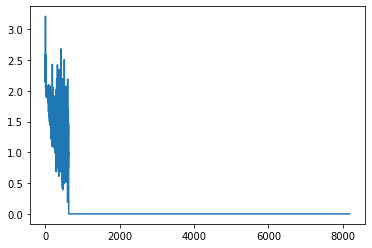

In [67]:
loss_values = np.ndarray.flatten(loss_values)
plt.plot(loss_values)

# Rollouts

In [68]:
#@title ### Rollout Function

def rollout(simulator, features, num_steps):
  """Rolls out a trajectory by applying the model in sequence."""
  
  initial_positions = features['pos'][0:INPUT_SEQUENCE_LENGTH]
  initial_velocities = features['vel'][0:INPUT_SEQUENCE_LENGTH]
  ground_truth_positions = features['pos'][INPUT_SEQUENCE_LENGTH:]
  ground_truth_velocities = features['vel'][INPUT_SEQUENCE_LENGTH:]
  global_context = None
  
  def step_fn(step, current_positions, current_velocities, predictions):

    if global_context is None:
      global_context_step = None
    else:
      global_context_step = global_context[
          step + INPUT_SEQUENCE_LENGTH - 1][tf.newaxis]

    next_position, next_velocity = simulator(
        current_positions,
        current_velocities,
        n_particles_per_example=tf.constant([N]),
        particle_types=None,
        global_context=global_context_step)

    # Update kinematic particles from prescribed trajectory.
    kinematic_mask = get_kinematic_mask(tf.zeros(N))
    next_position_ground_truth = ground_truth_positions[step,:,:]
    next_velocity_ground_truth = ground_truth_velocities[step,:,:]
    next_position = tf.where(tf.expand_dims(kinematic_mask,-1), next_position_ground_truth,
                             next_position)
    next_velocity = tf.where(tf.expand_dims(kinematic_mask,-1), next_velocity_ground_truth,
                             next_velocity)
    updated_predictions = predictions.write(step, next_position, next_velocity)

    # Shift `current_positions`, removing the oldest position in the sequence
    # and appending the next position at the end.
    next_positions = tf.concat([current_positions[1:,:,:],
                                next_position[tf.newaxis,:,:]], axis=0)
    next_velocities = tf.concat([current_velocities[1:,:,:],
                                next_velocity[tf.newaxis,:,:]], axis=0)
    
    return (step + 1, next_positions, next_velocities, updated_predictions)
  
  predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)

  _, _, _, predictions = tf.while_loop(
      cond=lambda step, state, vel, prediction: tf.less(step, num_steps),
      body=step_fn,
      #shape_invariants=[initial_positions.shape, initial_velocities.shape],
      loop_vars=(0, initial_positions, initial_velocities, predictions),
      parallel_iterations=1)

  output_dict = {
      'initial_positions': initial_positions,
      'initial_velocities': initial_velocities,
      'predicted_rollout': predictions.stack(),
      'ground_truth_rollout': ground_truth_positions
  }

  if global_context is not None:
    output_dict['global_context'] = global_context
  return output_dict

In [69]:
#@title ### Rollouts

num_steps = metadata['sequence_length'] - INPUT_SEQUENCE_LENGTH

ds = tf.data.TFRecordDataset(['train_datasets/microstates-' + str(i) + '.tfrecords' for i in range(1)])

# map the record to features
ds = ds.map(_parse_record)

# map the features to tensors
ds = ds.map(_parse_tensor)

#print(ds.element_spec)

def make_dataset(x):
    # make a dataset from the time series tensor
    pos = tf.data.Dataset.from_tensors((x['pos']))
    vel = tf.data.Dataset.from_tensors((x['vel']))

    data = tf.data.Dataset.zip((pos, vel))
    #data = data.flat_map(lambda pos_ds,vel_ds: tf.data.Dataset.zip((pos_ds,vel_ds)))

    return data

# flatten the windowed dataset
#ds = ds.map(make_dataset)

for databatch in ds:
    output = rollout(simulator,databatch,num_steps)
    break

output['metadata'] = metadata
filename = '/zonal_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(output, file)

In [70]:
print(output['predicted_rollout'])

tf.Tensor(
[[[ 187.3196     52.121643]
  [  99.004745   42.276726]
  [ 127.80989   171.0388  ]
  ...
  [  72.15165    86.843506]
  [  73.11959   192.30447 ]
  [  63.92454   393.41888 ]]

 [[ 191.26532    49.438282]
  [ 100.269196   39.10879 ]
  [ 129.7934    167.88138 ]
  ...
  [  76.07139    84.78435 ]
  [  69.306984  194.70361 ]
  [  61.79373   591.2456  ]]

 [[ 195.89478    47.541946]
  [ 102.215454   36.814934]
  [ 132.46751   165.47726 ]
  ...
  [  80.48414    83.48912 ]
  [  66.186356  197.96484 ]
  [  60.241512  789.97437 ]]

 ...

 [[ 538.58905   383.46436 ]
  [ 454.24      555.7926  ]
  [ 409.94608   673.173   ]
  ...
  [ 477.8751    554.5815  ]
  [ 185.37473   742.3703  ]
  [ 274.28964  9242.358   ]]

 [[ 549.4066    403.0667  ]
  [ 462.95325   582.67126 ]
  [ 415.95364   700.505   ]
  ...
  [ 490.08453   578.6365  ]
  [ 192.0376    767.3952  ]
  [ 284.25665  9476.884   ]]

 [[ 560.3113    423.20325 ]
  [ 471.58334   610.143   ]
  [ 421.86148   728.38226 ]
  ...
  [ 502.34634

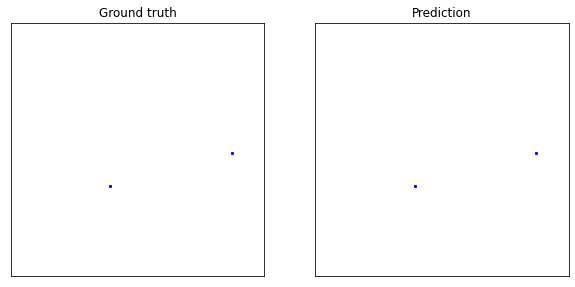

In [71]:
#@title ### Render Rollouts

TYPE_TO_COLOR = {
    3: "black",  # Boundary particles.
    0: "green",  # Rigid solids.
    7: "magenta",  # Goop.
    6: "gold",  # Sand.
    5: "blue",  # Water.
}

step_stride = 3
block_on_show = True

with open(filename, "rb") as file:
  rollout_data = pickle.load(file)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_info = []
for ax_i, (label, rollout_field) in enumerate(
    [("Ground truth", "ground_truth_rollout"),
      ("Prediction", "predicted_rollout")]):
  # Append the initial positions to get the full trajectory.
  trajectory = np.concatenate([
      rollout_data["initial_positions"],
      rollout_data[rollout_field]], axis=0)
  ax = axes[ax_i]
  ax.set_title(label)
  bounds = rollout_data["metadata"]["bounds"]
  ax.set_xlim(bounds[0][0], bounds[0][1])
  ax.set_ylim(bounds[1][0], bounds[1][1])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect(1.)
  points = {
      particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
      for particle_type, color in TYPE_TO_COLOR.items()}
  plot_info.append((ax, trajectory, points))

num_steps = trajectory.shape[0]

def update(step_i):
  outputs = []
  for _, trajectory, points in plot_info:
    for particle_type, line in points.items():
      #mask = rollout_data["particle_types"] == particle_type
      mask = True
      line.set_data(trajectory[step_i, mask, 0],
                    trajectory[step_i, mask, 1])
      outputs.append(line)
  return outputs

unused_animation = animation.FuncAnimation(
    fig, update,
    frames=np.arange(0, num_steps, step_stride), interval=10)
#plt.show(block=block_on_show)
rc('animation', html='jshtml')
unused_animation